# Recalibration of SMP density coefficients
*Josh King, Environment and Climate Change Canada, 2020*

The matched snow pit and SMP measurements from Part 1 are used to recalibrate the bilinear regression model of [Proksch et al. (2015)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JF003266). We apply a K-Folds approach to minimize sampling bias while evaluating the OLS regression. 

In [2]:
# Import community packages
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.cm as cm
import pickle

from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# Seed to replicate the paper result exactly
RANDOM_SEED = 2019

# Load comparison result from Part 1
result = pd.read_pickle('./output/smp_pit_filtered.pkl')
result['force_log'] = np.log(result['force_median'])
print(result.head())
print(list(result))



   count_samp   mean_samp  median_samp  stdev_samp   index  Index   Bin  \
1         6.0  250.671627   236.965383   30.443115  1392.0    5.0  10.0   
2         6.0  235.038446   228.638487   19.046244  1393.0    6.0  11.0   
3         6.0  270.949809   271.955707   10.760349  1394.0    7.0  19.0   
4         6.0  294.365412   293.751043    8.890766  1395.0    8.0  20.0   
5         6.0  310.598316   315.588186   13.027618  1396.0    9.0  21.0   

   ScannerID         RHO        SSA  ...  TYPE  relative_height         l  \
1     4900.0  251.664707   9.886767  ...     N            147.5  0.879808   
2     4900.0  261.534510   9.835250  ...     N            142.5  0.976932   
3     4900.0  304.558297  12.210600  ...     N            102.5  0.691499   
4     4900.0  352.791995  11.915575  ...     N             97.5  0.568636   
5     4900.0  337.253930  11.225220  ...     N             92.5  0.481754   

   force_median      error  campaign  ice_type        lat       long force_log  
1    

## K-Folds OLS method

OLS regression with 10 folds to minimize sampling bias.
Model coefficients and skill are evaluated as the mean of all folds. 

In [53]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)
rmse = []; error = []; r = []; params = None

# Split the dataset into 10 roughly equal groups, 
# train on all but one test group
for train_idx, test_idx in k_fold.split(result):
    train = result.iloc[train_idx]
    test = result.iloc[test_idx]
    
    model_rho = ols("SSA ~ force_log + force_log * l", train).fit()   #### changed RHO to SSA
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['SSA'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['SSA'])[1][0])
    error = np.append(error, predict_rho - test['SSA'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))

In [54]:
# K20a evaluation stats (from k-folds method)
# Metrics presented as mean of all fold permutations

k20a_rmse = rmse.mean()
k20a_bias = error.mean()
k20a_r2 = r.mean()**2

print('K20a recalibration evaluation')
print('N: %i' % len(result))
print('RMSE: %0.1f' % k20a_rmse)
print('RMSE percent: %0.2f' % np.round(k20a_rmse/result.SSA.mean(),2))
print('bias: %0.1f' % k20a_bias)
print('r^2: %0.2f' % k20a_r2)

K20a recalibration evaluation
N: 784
RMSE: 4.6
RMSE percent: 0.41
bias: -0.0
r^2: 0.03


In [55]:
model_k20a_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k20a_coeff)

# Save coeffs
filename = './output/density_k20a_coeffs.pkl'
pickle.dump(model_k20a_coeff, open(filename, 'wb'))

[14.03, -0.55, 0.1, -3.27]


In [56]:
# Apply the new coeffs to estimate density
k20a_rho = model_k20a_coeff[0]+(model_k20a_coeff[1]*result['force_log'])+ \
           (model_k20a_coeff[2]*result['force_log']*result['l'])+ \
           model_k20a_coeff[3]*result['l'] 

## K-folds OLS with outliers removed

Outliers were defined as SMP/Cutter comparisons where error > than the 95th quantile in the K20a recalibration.  
We justify this in the paper in the context of the matching procedure which cannot be assumed to be perfect.  
Note that this removes a small number of comparisons(n=10) which are not isolated to any one profile.

In [57]:
#Remove outliers
result_lim = result.copy()
result_lim['f_l'] = (result_lim['l'])*result_lim['force_log']
result_lim['abs_error'] = np.abs(k20a_rho - result_lim['SSA'])
q_95 = result_lim['abs_error'].quantile(0.95)
result_lim = result_lim[result_lim['abs_error'] < q_95]
n_removed  = len(result) - len(result_lim)

print('Error threshold: %i kg m^-3' % q_95)
print('Data points removed: %i' % n_removed)

Error threshold: 10 kg m^-3
Data points removed: 40


#### Figure 5 with caption
<img src="./output/figures/Fig05_RegressionTerms_lowres.png" alt="Figure 5" style="width: 800px;"/>

##### Comparison of the SMP regression parameters and corresponding snow density observations. Parameters include log-transformed median force (ln(F ̃)), microstructure length scale (L) and an interaction term (f ̃L). Relationships are separated by ice surface environment.'

In [58]:
print(list(result_lim))

['count_samp', 'mean_samp', 'median_samp', 'stdev_samp', 'index', 'Index', 'Bin', 'ScannerID', 'RHO', 'SSA', 'y', 'anisotropy', 'position in sample (mm)', 'position in snowpit(mm)', 'relative depth (%) ', 'BOTTOM', 'TOP', 'Height correction mm', 'ID', 'Location', 'Datetime', 'TYPE', 'relative_height', 'l', 'force_median', 'error', 'campaign', 'ice_type', 'lat', 'long', 'force_log', 'f_l', 'abs_error']


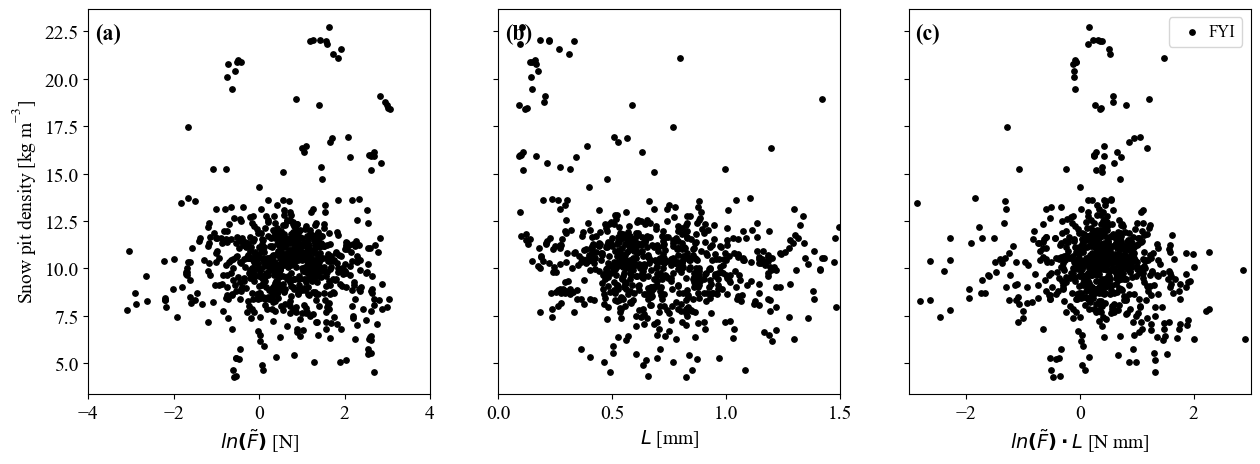

In [59]:
# Code to construct Figure 5
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

axs = [ax1, ax2, ax3]
for n, ax in enumerate(axs):
    ax.text(0.02, 0.92, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=16, weight='bold')

axis_value_size = 14
axis_label_szie = 14
point_size = 15

ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)

kws_myi = dict(color = 'deepskyblue', s = point_size)
kws_fyi = dict(color = 'black', s = point_size)

ax1.scatter(result_lim['force_log'], #[result_lim['ice_type'] == 'f']
            result_lim['SSA'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax1.scatter(result_lim[result_lim['ice_type'] == 'm']['force_log'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)


ax2.scatter(result_lim['l'], #[result_lim['ice_type'] == 'f']
            result_lim['SSA'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax2.scatter(result_lim[result_lim['ice_type'] == 'm']['l'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)

ax3.scatter(result_lim['f_l'], #[result_lim['ice_type'] == 'f']
            result_lim['SSA'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax3.scatter(result_lim[result_lim['ice_type'] == 'm']['f_l'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)

ax1.set_ylabel('Snow pit ssa [kg m$\mathregular{^{-3}}$]', fontsize = axis_label_szie)
ax1.set_xlabel(r'$ln(\tilde{F})$ [N]', fontsize = axis_label_szie)
ax2.set_xlabel(r'$L$ [mm]', fontsize = axis_label_szie)
ax3.set_xlabel(r'$ln(\tilde{F}) \cdot L$ [N mm]', fontsize = axis_label_szie)

ax1.set_xlim(-4, 4)
ax2.set_xlim(0, 1.5)
ax3.set_xlim(-3, 3)

ax3.legend(fontsize = 12)
ax3.legend(handletextpad=0, fontsize=12)


f.savefig('./output/figures/Fig05_RegressionTerms_lowres.png', format='png')
f.savefig('./output/figures/Fig05_RegressionTerms_production.pdf', format='pdf', dpi = 300)

In [60]:
# Correlation between snow pit observed density and median force.L for all comparisons
print(np.round(np.corrcoef(result_lim.SSA, result_lim.force_log)[0][1],2))

0.07


In [61]:
# Correlation between snow pit observed density and median force, microstructural length scale and the interaction term
result_lim.groupby(['Location'])[['SSA','force_log','l','f_l']].corr()

SSA  force_log         l       f_l
Location                                                        
FR            SSA        1.000000   0.049191 -0.776456  0.256369
              force_log  0.049191   1.000000 -0.298479  0.909924
              l         -0.776456  -0.298479  1.000000 -0.580646
              f_l        0.256369   0.909924 -0.580646  1.000000
RS3           SSA        1.000000   0.198180 -0.476675 -0.095134
              force_log  0.198180   1.000000 -0.552784  0.893758
              l         -0.476675  -0.552784  1.000000 -0.219284
              f_l       -0.095134   0.893758 -0.219284  1.000000
RS4           SSA        1.000000   0.123556 -0.429201 -0.147229
              force_log  0.123556   1.000000 -0.483526  0.855846
              l         -0.429201  -0.483526  1.000000 -0.107685
              f_l       -0.147229   0.855846 -0.107685  1.000000
Snow2-A2      SSA        1.000000   0.139350 -0.369131  0.071788
              force_log  0.139350   1.000000 -0.368925  0.922595
              l         -0.369131  -0.368925  1.000000 -0.222022
              f_l        0.071788   0.922595 -0.222022  1.000000
Snow2-A8      SSA        1.000000   0.109034  0.162978  0.161719
              force_log  0.109034   1.000000 -0.562110  0.886560
              l          0.162978  -0.562110  1.000000 -0.576528
              f_l        0.161719   0.886560 -0.576528  1.000000
ds-coring-SYI SSA        1.000000  -0.286445  0.306536  0.054318
              force_log -0.286445   1.000000 -0.094053  0.766402
              l          0.306536  -0.094053  1.000000  0.519662
              f_l        0.054318   0.766402  0.519662  1.000000
radiation-stn SSA        1.000000  -0.186978  0.047585 -0.159170
              force_log -0.186978   1.000000 -0.545663  0.896996
              l          0.047585  -0.545663  1.000000 -0.392865
              f_l       -0.159170   0.896996 -0.392865  1.000000
snow1-A3      SSA        1.000000  -0.144383 -0.381825 -0.160684
              force_log -0.144383   1.000000 -0.538216  0.935082
              l         -0.381825  -0.538216  1.000000 -0.279762
              f_l       -0.160684   0.935082 -0.279762  1.000000
snow1-A5      SSA        1.000000   0.249991 -0.452281  0.136380
              force_log  0.249991   1.000000 -0.711817  0.915182
              l         -0.452281  -0.711817  1.000000 -0.523656
              f_l        0.136380   0.915182 -0.523656  1.000000
snow2-A2      SSA        1.000000  -0.223595  0.056179 -0.292019
              force_log -0.223595   1.000000 -0.485506  0.907009
              l          0.056179  -0.485506  1.000000 -0.353377
              f_l       -0.292019   0.907009 -0.353377  1.000000
snow2-A8      SSA        1.000000   0.259547 -0.470393 -0.258642
              force_log  0.259547   1.000000 -0.463809  0.758324
              l         -0.470393  -0.463809  1.000000 -0.047278
              f_l       -0.258642   0.758324 -0.047278  1.000000
snow3-A6      SSA        1.000000   0.065483 -0.287644  0.132320
              force_log  0.065483   1.000000 -0.743878  0.825039
              l         -0.287644  -0.743878  1.000000 -0.677486
              f_l        0.132320   0.825039 -0.677486  1.000000

In [62]:
# Correlation between snow pit observed density and median force, microstructural length scale and the interaction term
result_lim.groupby(['campaign','Location'])[['SSA','force_log','l','f_l']].corr()

SSA  force_log         l       f_l
campaign Location                                                        
f1       FR            SSA        1.000000   0.049191 -0.776456  0.256369
                       force_log  0.049191   1.000000 -0.298479  0.909924
                       l         -0.776456  -0.298479  1.000000 -0.580646
                       f_l        0.256369   0.909924 -0.580646  1.000000
         RS3           SSA        1.000000   0.198180 -0.476675 -0.095134
                       force_log  0.198180   1.000000 -0.552784  0.893758
                       l         -0.476675  -0.552784  1.000000 -0.219284
                       f_l       -0.095134   0.893758 -0.219284  1.000000
         RS4           SSA        1.000000   0.123556 -0.429201 -0.147229
                       force_log  0.123556   1.000000 -0.483526  0.855846
                       l         -0.429201  -0.483526  1.000000 -0.107685
                       f_l       -0.147229   0.855846 -0.107685  1.000000
         Snow2-A2      SSA        1.000000   0.139350 -0.369131  0.071788
                       force_log  0.139350   1.000000 -0.368925  0.922595
                       l         -0.369131  -0.368925  1.000000 -0.222022
                       f_l        0.071788   0.922595 -0.222022  1.000000
         Snow2-A8      SSA        1.000000   0.109034  0.162978  0.161719
                       force_log  0.109034   1.000000 -0.562110  0.886560
                       l          0.162978  -0.562110  1.000000 -0.576528
                       f_l        0.161719   0.886560 -0.576528  1.000000
         ds-coring-SYI SSA        1.000000  -0.286445  0.306536  0.054318
                       force_log -0.286445   1.000000 -0.094053  0.766402
                       l          0.306536  -0.094053  1.000000  0.519662
                       f_l        0.054318   0.766402  0.519662  1.000000
         radiation-stn SSA        1.000000  -0.186978  0.047585 -0.159170
                       force_log -0.186978   1.000000 -0.545663  0.896996
                       l          0.047585  -0.545663  1.000000 -0.392865
                       f_l       -0.159170   0.896996 -0.392865  1.000000
         snow1-A3      SSA        1.000000  -0.144383 -0.381825 -0.160684
                       force_log -0.144383   1.000000 -0.538216  0.935082
                       l         -0.381825  -0.538216  1.000000 -0.279762
                       f_l       -0.160684   0.935082 -0.279762  1.000000
         snow1-A5      SSA        1.000000   0.249991 -0.452281  0.136380
                       force_log  0.249991   1.000000 -0.711817  0.915182
                       l         -0.452281  -0.711817  1.000000 -0.523656
                       f_l        0.136380   0.915182 -0.523656  1.000000
         snow2-A2      SSA        1.000000  -0.223595  0.056179 -0.292019
                       force_log -0.223595   1.000000 -0.485506  0.907009
                       l          0.056179  -0.485506  1.000000 -0.353377
                       f_l       -0.292019   0.907009 -0.353377  1.000000
         snow2-A8      SSA        1.000000   0.259547 -0.470393 -0.258642
                       force_log  0.259547   1.000000 -0.463809  0.758324
                       l         -0.470393  -0.463809  1.000000 -0.047278
                       f_l       -0.258642   0.758324 -0.047278  1.000000
         snow3-A6      SSA        1.000000   0.065483 -0.287644  0.132320
                       force_log  0.065483   1.000000 -0.743878  0.825039
                       l         -0.287644  -0.743878  1.000000 -0.677486
                       f_l        0.132320   0.825039 -0.677486  1.000000

In [63]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)

rmse = []
error = []
r = []
params = None

for train_idx, test_idx in k_fold.split(result_lim):
    train = result_lim.iloc[train_idx]
    test = result_lim.iloc[test_idx]
    
    model_rho = ols("SSA ~ force_log + force_log * l + l", train).fit()
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['SSA'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['SSA'])[1][0])
    error = np.append(error, predict_rho - test['SSA'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))

In [64]:
# K20a evaluation stats (from kfolds method)
k20b_rmse = rmse.mean()
k20b_bias = error.mean()
k20b_r2 = r.mean()**2

print('K20b recalibration evaluation')
print('N: %i' % len(result_lim))
print('RMSE: %0.1f' % k20b_rmse)
print('RMSE percent: %0.2f' % np.round(k20b_rmse/result_lim.RHO.mean(),2))
print('bias: %0.1f' % k20b_bias)
print('r^2: %0.2f' % k20b_r2)

K20b recalibration evaluation
N: 744
RMSE: 2.5
RMSE percent: 0.01
bias: -0.0
r^2: 0.06


In [65]:
model_k20b_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k20b_coeff)

# Save coeffs
filename = './output/density_k20b_coeffs.pkl'
pickle.dump(model_k20b_coeff, open(filename, 'wb'))

[11.72, 0.51, -0.92, -1.82]


In [66]:
k20b_rho = model_k20b_coeff[0]+(model_k20b_coeff[1]*result_lim['force_log'])+ \
           (model_k20b_coeff[2]*result_lim['force_log']*result_lim['l'])+ \
           model_k20b_coeff[3]*result_lim['l']

#### Figure 4 with caption
<img src="./output/figures/Fig04_ModelEval_lowres.png" alt="Figure 4" style="width: 600px;"/>

##### Evaluation of the SMP density model parametrization of Proksch et al. (2015) (P15; Top) and recalibrated coefficients for snow on sea ice (K19b; Bottom). In both cases the model is evaluated against manual density cutter measurements of snow density.

C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


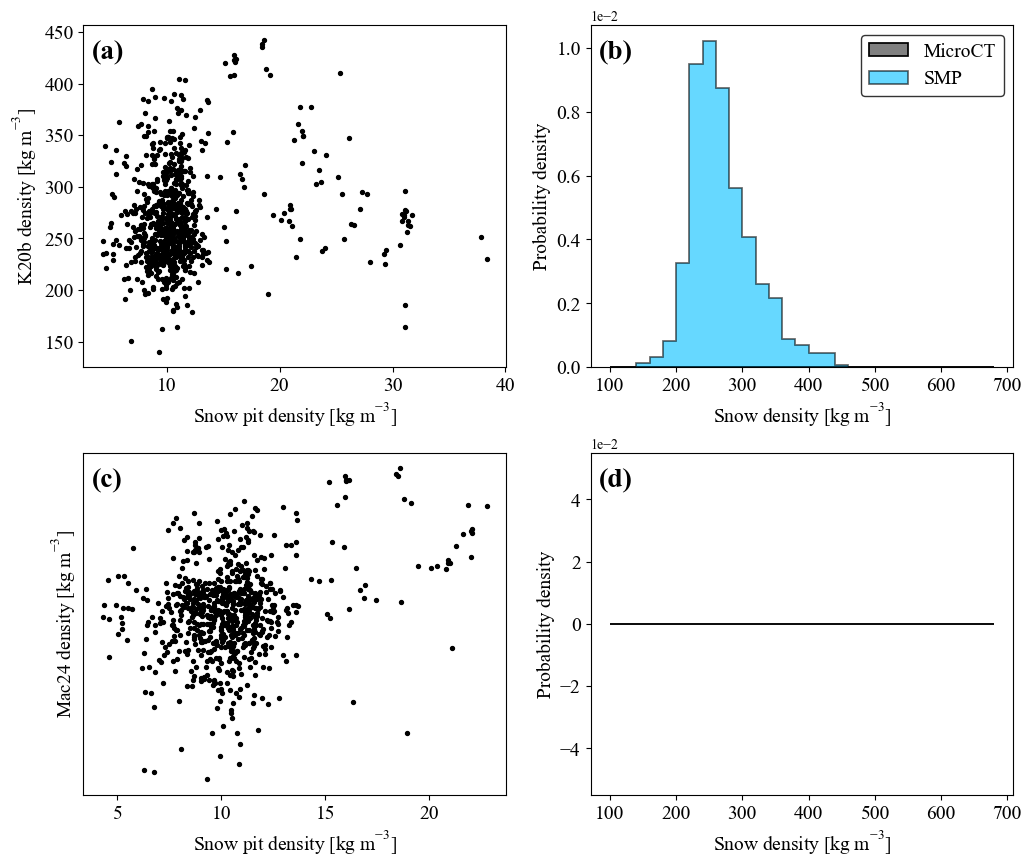

In [71]:
# Code to construct Figure 4
# P15 statistics
p2015_rmse = np.sqrt(np.mean((result['mean_samp']-result['SSA'])**2))
p2015_bias = (result['error']).mean()
p2015_r2 = np.ma.corrcoef(result['mean_samp'],result['SSA'])[0, 1]**2
p2015_n = len(result['mean_samp'])
p2015_p = stats.pearsonr(result['mean_samp'],result['SSA'])[1]


# Fig constants
axis_value_size = 14
axis_label_size = 14
rho_bin_size = 20 #in kg m-3
line_start_a = 100
line_end_a = 700
line_end_b = 550
point_size = 8
common_bin = np.arange(line_start_a,line_end_a, rho_bin_size)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
f.subplots_adjust(hspace=.25)

axs = [ax1, ax2, ax3, ax4]
for n, ax in enumerate(axs):
    ax.text(0.02, 0.9, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=20, weight='bold')

# ax1.set_xlim(line_start_a,line_end_a)
# ax1.set_ylim(line_start_a,line_end_a)
# ax2.set_xlim(line_start_a,line_end_a)
# ax3.set_xlim(line_start_a,line_end_b)
# ax3.set_ylim(line_start_a,line_end_b)
# ax4.set_xlim(line_start_a,line_end_b)

ax3.set_yticks(np.arange(line_start_a, line_end_b+1, 100.0))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax4.tick_params(axis='both', which='major', labelsize=axis_value_size)


ax1.scatter(result['SSA'], result['mean_samp'], 
            s = point_size, color ='black', zorder = 1000)
# ax1.plot([line_start_a, line_end_a], [line_start_a, line_end_a], 
#          'k-', color = 'gray' ,alpha= 0.8, zorder = 500)

hist_kws = dict(density=True, bins=common_bin, histtype="stepfilled", linewidth=1.25)
ax2.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)
ax2.hist(result['SSA'], alpha = 1, edgecolor="black", 
         color = 'grey', label = 'MicroCT', **hist_kws)
ax2.hist(result['mean_samp'], alpha = 0.6, edgecolor="black", 
         color = 'deepskyblue', label = 'SMP', **hist_kws)

ax1.set_ylabel('K20b density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax1.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.set_ylabel('Probability density', fontsize=axis_label_size)
ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.legend(edgecolor = 'black',  fontsize=axis_value_size)

ax3.scatter(result_lim['SSA'], k20b_rho, s = point_size, color ='black',  zorder = 1000)
# ax3.plot([line_start_a, line_end_b], [line_start_a, line_end_b], 
#          'k-', color = 'grey' ,alpha= 0.8,  zorder = 500)

hist_kws = dict(density=True, bins = common_bin, histtype= "stepfilled", linewidth = 1.25)
ax4.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)

ax4.hist(result_lim['SSA'], alpha = 1, edgecolor="black", color = 'grey', label = 'MicroCT', **hist_kws)
ax4.hist(k20b_rho, alpha = 0.6, edgecolor="black", color = 'deepskyblue', label = 'SMP', **hist_kws)

ax3.set_ylabel('Mac24 density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax3.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax4.set_ylabel('Probability density',fontsize=axis_label_size)
ax4.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)

# Display stats
# ax1.text(550, 150,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(p2015_n, p2015_rmse, p2015_r2), fontsize=12)
# ax3.text(440, 130,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(len(result_lim), k20b_rmse, k20b_r2),  fontsize=12)

f.savefig('./output/figures/Fig04_ModelEval_lowres.png', format='png')
f.savefig('./output/figures/Fig04_ModelEval_production.pdf', format='pdf', dpi = 300)

In [68]:
# Error metrics
def rmse(data):
    return np.sqrt(np.mean(data**2))

result_lim['model_rho'] = k20b_rho
result_lim['abs_error'] = np.abs(k20b_rho-result_lim['RHO']).values
result_lim['error'] = (k20b_rho-result_lim['SSA']).values

# Error by layer type
np.round(result_lim.groupby('TYPE')['error'].apply(rmse)/result_lim.groupby('TYPE')['model_rho'].mean(),3)

TYPE
N    0.241
dtype: float64

In [69]:
np.round(result_lim.groupby('campaign')['error'].apply(rmse)/result_lim.groupby('campaign')['model_rho'].mean(),3)

campaign
f1    0.241
dtype: float64

In [70]:
# Overall error in %
np.round((rmse(result_lim['error'])/result_lim['model_rho'].mean()),3)

0.241